In [1]:
from google.colab import files
uploaded = files.upload()

Saving v6_remove_punctuation_remove_non_english_correct_spelling_replace_short_form_slang.csv to v6_remove_punctuation_remove_non_english_correct_spelling_replace_short_form_slang.csv


In [2]:
from glob import glob 
import pandas as pd
import numpy as np
import re
import string
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.offline import iplot

from textblob import TextBlob
import spacy
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD 
from collections import Counter

In [3]:
data = pd.read_csv("v6_remove_punctuation_remove_non_english_correct_spelling_replace_short_form_slang.csv")

In [4]:
data.head()

,post_id,text,post_text,shared_text,time,image,video,video_thumbnail,video_id,num_reactions,num_comments,num_shares,post_url,link,user_id,username,is_live,factcheck,shared_post_id,shared_time,shared_user_id,shared_username,shared_post_url,available,images,w3_fb_url,fetched_time,num_like,num_love,num_support,num_haha,num_wow,num_sorry,num_anger,label
0,3.071615e+15,D,:D\r\n-\r\n#71512: https://www.nuswhispers.com...,NaN,2019-10-21 14:35:00,https://scontent.fsin3-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,113,8,0,https://facebook.com/nuswhispers/posts/3071615...,https://www.nuswhispers.com/confession/71512,695707917166339,NUSWhispers,False,NaN,NaN,NaN,NaN,NaN,NaN,True,['https://scontent.fsin3-1.fna.fbcdn.net/v/t1....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,3.043380e+15,Im sorry SpongeBob,...I'm sorry SpongeBob\r\n-\r\n#71125: https:/...,NaN,2019-10-12 08:29:15,https://scontent.fsin3-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,27,3,0,https://facebook.com/nuswhispers/posts/3043381...,https://www.nuswhispers.com/confession/71125,695707917166339,NUSWhispers,False,NaN,NaN,NaN,NaN,NaN,NaN,True,['https://scontent.fsin3-1.fna.fbcdn.net/v/t1....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3.725412e+15,Dont chase after who you like If you are meant...,"""Don't chase after who you like. If you are me...",NaN,2020-05-09 12:42:39,NaN,NaN,NaN,NaN,19,4,1,https://facebook.com/story.php?story_fbid=3725...,https://www.nuswhispers.com/confession/83815,695707917166339,NUSWhispers,False,NaN,NaN,NaN,NaN,NaN,NaN,True,[],https://www.facebook.com/nuswhispers/posts/372...,2021-03-24 00:13:47,18.0,NaN,NaN,NaN,NaN,1.0,NaN,0
3,3.003306e+15,Friends shouldnt expect anything in return Thi...,"""Friends shouldn't expect anything in return.""...",NaN,2019-09-28 03:43:18,NaN,NaN,NaN,NaN,22,15,3,https://facebook.com/story.php?story_fbid=3003...,https://www.nuswhispers.com/confession/70357,695707917166339,NUSWhispers,False,NaN,NaN,NaN,NaN,NaN,NaN,True,[],https://www.facebook.com/nuswhispers/posts/300...,2021-03-23 12:01:36,16.0,NaN,NaN,NaN,NaN,6.0,NaN,2
4,2.529602e+15,I will stop procrastinating and catch up with ...,"""I will stop procrastinating and catch up with...",NaN,2019-03-26 10:58:45,NaN,NaN,NaN,NaN,7,2,2,https://facebook.com/story.php?story_fbid=2529...,https://www.nuswhispers.com/confession/60619,695707917166339,NUSWhispers,False,NaN,NaN,NaN,NaN,NaN,NaN,True,[],https://www.facebook.com/nuswhispers/posts/252...,2021-03-24 15:32:49,6.0,NaN,NaN,1.0,NaN,NaN,NaN,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4407 entries, 0 to 4406
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   post_id          4407 non-null   float64
 1   text             4407 non-null   object 
 2   post_text        4407 non-null   object 
 3   shared_text      533 non-null    object 
 4   time             4407 non-null   object 
 5   image            293 non-null    object 
 6   video            6 non-null      object 
 7   video_thumbnail  6 non-null      object 
 8   video_id         6 non-null      float64
 9   num_reactions    4407 non-null   int64  
 10  num_comments     4407 non-null   int64  
 11  num_shares       4407 non-null   int64  
 12  post_url         4407 non-null   object 
 13  link             4381 non-null   object 
 14  user_id          4407 non-null   int64  
 15  username         4407 non-null   object 
 16  is_live          4407 non-null   bool   
 17  factcheck     

In [6]:
# choose some interested columns
# data = data[["post_id", "text", "time", "num_reactions", "num_comments", "num_shares", "num_like", "num_love", "num_support", "num_haha", "num_wow", "num_sorry", "num_anger"]]
data = data[["post_id", "text", "label"]]

In [7]:
data.head()

,post_id,text,label
0,3.071615e+15,D,0
1,3.043380e+15,Im sorry SpongeBob,0
2,3.725412e+15,Dont chase after who you like If you are meant...,0
3,3.003306e+15,Friends shouldnt expect anything in return Thi...,2
4,2.529602e+15,I will stop procrastinating and catch up with ...,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4407 entries, 0 to 4406
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   post_id  4407 non-null   float64
 1   text     4407 non-null   object 
 2   label    4407 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 103.4+ KB


In [9]:
negativity = data['label'].value_counts()
labels = list(negativity.index) # [0, 1, 2, 3, 4]
values = list(negativity.values) # [1508, 1219, 934, 563, 183]

# print(negativity)
print(labels)
print(values)

[0, 1, 2, 3, 4]
[1508, 1219, 934, 563, 183]


In [10]:
trace1 = go.Pie(labels = labels, values = values, marker = dict(colors=['red']))

layout = go.Layout(title = 'Distribution of Negativity Levels (0-4)', legend = dict(orientation = 'v'), height=500, width=500)

fig = go.Figure(data=[trace1], layout = layout)
fig.update_layout(title_x=0.5)
iplot(fig)

In [11]:
# split into train-validation-test data, to visualise distribution of labels in the different sets
from sklearn.model_selection import train_test_split
train_features = data[["text"]]
label = data["label"]

train_features, validation_features, train_label, validation_label = train_test_split(train_features, label, test_size=0.2, random_state=10)
test_features, validation_features, test_label, validation_label = train_test_split(validation_features, validation_label, test_size=0.5, random_state=10)

In [12]:
# look at train
negativity = train_label.value_counts()
labels = list(negativity.index) # [0, 1, 2, 3, 4]
values = list(negativity.values) # [1214, 974, 761, 432, 144]

print(labels)
print(values)

trace1 = go.Pie(labels = labels, values = values, marker = dict(colors=['red']))

layout = go.Layout(title = 'Distribution of Negativity Levels in Training Data (0-4)', legend = dict(orientation = 'v'), height=500, width=500)

fig = go.Figure(data=[trace1], layout = layout)
fig.update_layout(title_x=0.5)
iplot(fig)

[0, 1, 2, 3, 4]
[1214, 974, 761, 432, 144]


In [13]:
# look at validation
negativity = validation_label.value_counts()
labels = list(negativity.index) # [0, 1, 2, 3, 4]
values = list(negativity.values) # [154, 128, 76, 63, 20]

print(labels)
print(values)

trace1 = go.Pie(labels = labels, values = values, marker = dict(colors=['red']))

layout = go.Layout(title = 'Distribution of Negativity Levels in Validation Data (0-4)', legend = dict(orientation = 'v'), height=500, width=500)

fig = go.Figure(data=[trace1], layout = layout)
fig.update_layout(title_x=0.5)
iplot(fig)

[0, 1, 2, 3, 4]
[154, 128, 76, 63, 20]


In [14]:
# look at test_label
negativity = test_label.value_counts()
labels = list(negativity.index) # [0, 1, 2, 3, 4]
values = list(negativity.values) # [140, 117, 97, 68, 19]

print(labels)
print(values)

trace1 = go.Pie(labels = labels, values = values, marker = dict(colors=['red']))

layout = go.Layout(title = 'Distribution of Negativity Levels in Test Data (0-4)', legend = dict(orientation = 'v'), height=500, width=500)

fig = go.Figure(data=[trace1], layout = layout)
fig.update_layout(title_x=0.5)
iplot(fig)

[0, 1, 2, 3, 4]
[140, 117, 97, 68, 19]


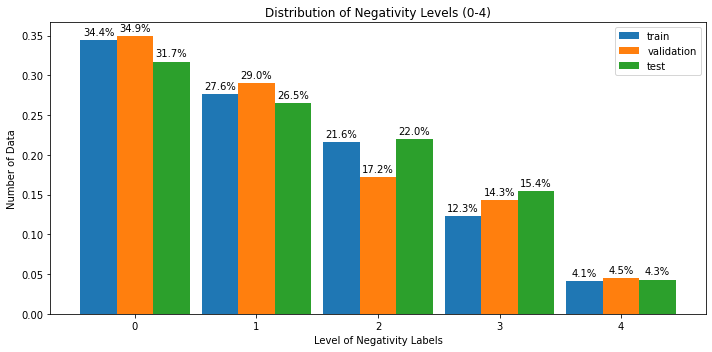

In [15]:
X = ['0','1','2','3','4']
Ytrain = list(train_label.value_counts(normalize=True).values)
Yvalidation = list(validation_label.value_counts(normalize=True).values)
Ytest = list(test_label.value_counts(normalize=True).values)

# print(Ytrain)
# print(Yvalidation)
# print(Ytest)  

X_axis = np.arange(len(X))
  
# plt.bar(X_axis - 0.3, Ytrain, 0.3, label = 'train')
# plt.bar(X_axis, Yvalidation, 0.3, label = 'validation')
# plt.bar(X_axis + 0.3, Ytest, 0.3, label = 'test')


fig, ax = plt.subplots()
rects1 = ax.bar(X_axis - 0.3, Ytrain, 0.3, label = 'train')
rects2 = ax.bar(X_axis, Yvalidation, 0.3, label = 'validation')
rects3 = ax.bar(X_axis + 0.3, Ytest, 0.3, label = 'test')
  
plt.xticks(X_axis, X)
plt.xlabel("Level of Negativity Labels")
plt.ylabel("Number of Data")
plt.title("Distribution of Negativity Levels (0-4)")
plt.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        label = (height * 100).round(1).astype(str) + '%'
        ax.annotate('{}'.format(label),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
fig.set_size_inches(10, 5, forward=True)
# fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
plt.show()

In [16]:
data.isnull().sum()
# data.info()

post_id    0
text       0
label      0
dtype: int64

In [17]:
# check if any duplicates based on post_id
print(data.shape) # (4407, 3)
data = data.drop_duplicates(subset = 'post_id')
print(data.shape) # no duplicates ~ (4375, 3)

(4407, 3)
(4375, 3)


In [18]:
data = data.dropna(axis = 0, subset=['text'], inplace=False)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4375 entries, 0 to 4406
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   post_id  4375 non-null   float64
 1   text     4375 non-null   object 
 2   label    4375 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 136.7+ KB


In [20]:
data.head()

,post_id,text,label
0,3.071615e+15,D,0
1,3.043380e+15,Im sorry SpongeBob,0
2,3.725412e+15,Dont chase after who you like If you are meant...,0
3,3.003306e+15,Friends shouldnt expect anything in return Thi...,2
4,2.529602e+15,I will stop procrastinating and catch up with ...,0


In [21]:
# preprocess text, take away text after last #
data['text'] = data['text'].apply(lambda x: x[0:x.rfind("#")] if x.rfind("#") != -1 else x)

In [22]:
# perform text cleaning (symbols, punctuations, stopwords) to make it more understandable and get better insights
# expand contractions (?), lowercase the reviews (?), remove digits and words containing digits (?), remove punctuations (?)
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))


# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
data['text']=data['text'].apply(lambda x:expand_contractions(x))

In [23]:
# can decide whether to lowercase later
data['text']=data['text'].apply(lambda x: x.lower())

In [24]:
# Remove digits and words containing digits (because they do not give much importance to the main words)
data['text']=data['text'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [25]:
# Remove punctuations (eg. commas, hyphens, full stops)
data['text']=data['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [26]:
# Remove extra spaces present in the data
data['text']=data['text'].apply(lambda x: re.sub(' +',' ',x))

In [27]:
for index, text in enumerate(data['text'][36:40]):
  print('Text %d: \n' %(index+1), text)

Text 1: 
 this message is for all inconsiderate people who cut the queue i am a os student and i was waiting in a long queue at today to collect the digital thermometer that the department is handing out to students then i saw an asian guy in a white shirt and an indian girl wearing gold earrings walking towards me both were from bi disregarding the long line behind them they just casually cut the queue in front of me and acted as if nothing happened i was significant other frustrated and the people in front and behind me was tf they ignored all the intense glare from people eventually reached the front of the line haa but good for them they were refused to be given a thermometer because they weren even us os students if i heard correctly they were some people working in bi i am quite glad that our supplies were not wasted on those inconsiderate people to all people who dare to cut the line i dont care if your friends were lining for you already we have a very limited supply thermomete

significant 4486
just 4107
like 3647
im 3434
dont 2983
really 2592
time 2425
know 2315
feel 1867
people 1833
want 1765
think 1539
friends 1528
life 1345
work 1290
years 1248
good 1220
relationship 1182
things 1150
guy 1062


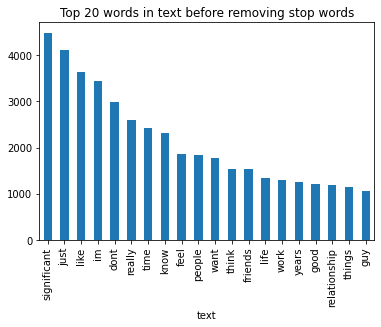

In [28]:
# Distribution of top unigrams before removing stop words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(data['text'], 20)

for word, freq in common_words:
    print(word, freq)

df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df1.groupby('text').sum()['count'].sort_values(ascending=False).plot.bar(
    title='Top 20 words in text before removing stop words')

significant other 4469
in the 1742
to be 1586
of the 1406
want to 1268
it is 946
to the 907
for the 896
of my 807
to do 786
if you 758
me to 756
on the 749
to get 704
the same 683
have been 661
to me 657
at the 613
for me 604
in my 593


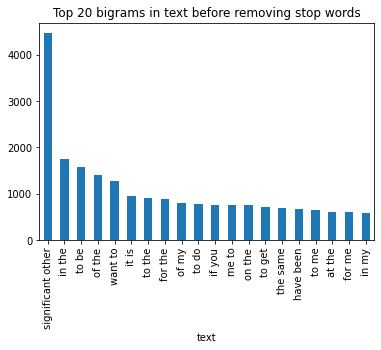

In [29]:
# distribution of top bigrams before removing stop words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(data['text'], 20)

for word, freq in common_words:
    print(word, freq)

df3 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df3.groupby('text').sum()['count'].sort_values(ascending=False).plot.bar(
    title='Top 20 bigrams in text before removing stop words')

significant other much 368
dont want to 192
significant other many 181
what should do 179
would like to 173
be able to 170
for me to 165
one of the 157
feel significant other 142
what to do 142
significant other that 140
is significant other 137
just want to 133
know how to 124
not sure if 124
if you are 122
want to be 120
told me that 119
in the future 116
to talk to 115


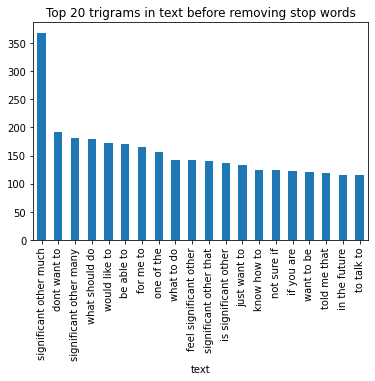

In [30]:
# distribution of Top trigrams before removing stop words
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(data['text'], 20)

for word, freq in common_words:
    print(word, freq)

df5 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df5.groupby('text').sum()['count'].sort_values(ascending=False).plot.bar(
    title='Top 20 trigrams in text before removing stop words')

In [31]:
from textblob import TextBlob
data['polarity'] = data['text'].map(lambda x: TextBlob(x).sentiment.polarity)

In [32]:
data.head()

,post_id,text,label,polarity
0,3.071615e+15,d,0,0.000000
1,3.043380e+15,im sorry spongebob,0,-0.500000
2,3.725412e+15,dont chase after who you like if you are meant...,0,0.248611
3,3.003306e+15,friends shouldnt expect anything in return thi...,2,0.002296
4,2.529602e+15,i will stop procrastinating and catch up with ...,0,0.000000


In [ ]:
# df['polarity'].iplot(
#     kind='hist',
#     bins=50,
#     xTitle='polarity',
#     linecolor='black',
#     yTitle='count',
#     title='Sentiment Polarity Distribution')

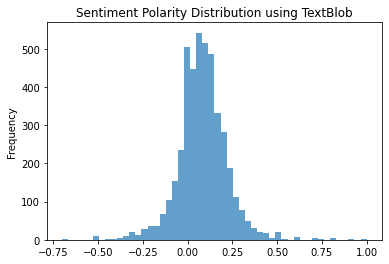

In [33]:
data['polarity'].plot.hist(
    bins=50,
    alpha = 0.7,
    title='Sentiment Polarity Distribution using TextBlob')

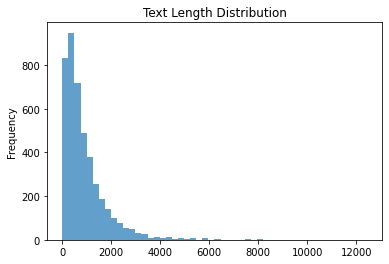

In [34]:
# Distribution of 'text' lengths
data['text_len'] = data['text'].apply(lambda x: len(x))
data['text_len'].plot.hist(
    bins=50,
    alpha = 0.7,
    title='Text Length Distribution')

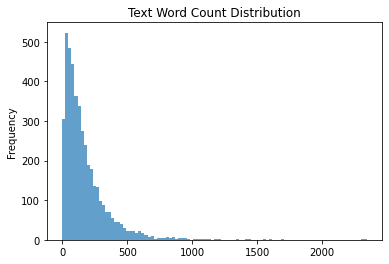

In [35]:
# Distribution of text word count
data['word_count'] = data['text'].apply(lambda x: len(str(x).split()))
data['word_count'].plot.hist(
    bins=100,
    alpha = 0.7,
    title='Text Word Count Distribution')

In [36]:
data.describe()

,post_id,label,polarity,text_len,word_count
count,4.375000e+03,4375.000000,4375.000000,4375.000000,4375.000000
mean,3.735061e+15,1.249371,0.082981,909.510629,174.126629
std,8.925538e+14,1.173645,0.139307,943.337752,179.917058
min,2.408577e+15,0.000000,-0.700000,1.000000,0.000000
25%,2.930491e+15,0.000000,0.000000,313.000000,60.000000
50%,3.569854e+15,1.000000,0.079783,633.000000,122.000000
75%,4.694829e+15,2.000000,0.156738,1187.000000,226.000000
max,5.168800e+15,4.000000,1.000000,12423.000000,2343.000000


In [37]:
# explore topic modelling algorithm with this dataset
# experiment with Latent Semantic Analysis (LSA) technique in topic modelling
# to better understand each topic, we find the most frequent 3 words in each topic
# will tell us if topic modelling techniques will be useful for our project
# eg whether we will reach any degree of separation across topic categories

reindexed_data = data['text']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)
n_topics = 10 # adjust this
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
    
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words
    
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  significant just im
Topic 2:  prof students ben
Topic 3:  girls guys guy
Topic 4:  nutshell luminous renamed
Topic 5:  im student hi
Topic 6:  year job company
Topic 7:  prof ben love
Topic 8:  parents money buy
Topic 9:  students modules school
Topic 10:  friends people life


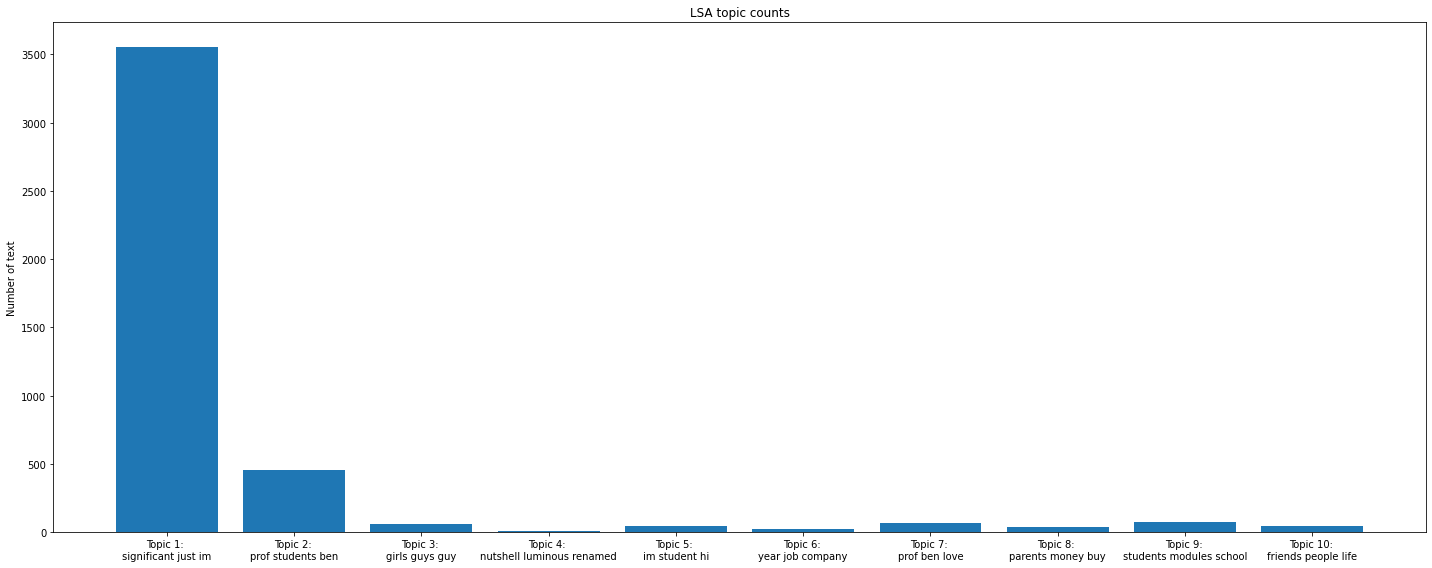

In [38]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i+1) + top_3_words[i] for i in lsa_categories]
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of text');
ax.set_title('LSA topic counts');
fig.tight_layout()
plt.show();

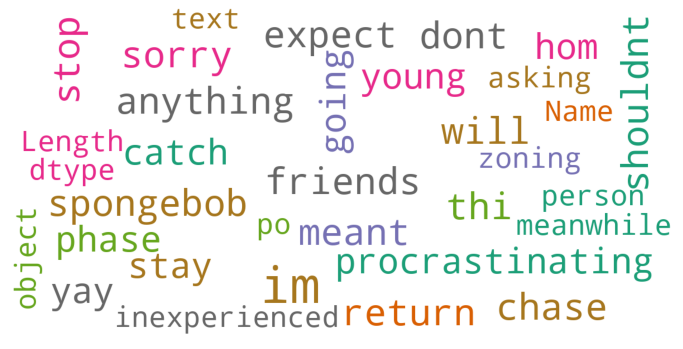

In [39]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        colormap="Dark2",
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(data['text'])

In [ ]:
# stopwords removal - decrease dataset size, and increase focus on meaningful words
# lemmatization - reducate a token to its lemma, uses vocabulary, word structure, pos tags, and gramma relations to convert a word to its base form
# create document term matrix

In [40]:
# use SpaCy for the removal of stopwords and lemmatization
import spacy

nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
data['text']=data['text'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [41]:
for index, text in enumerate(data['text'][36:40]):
  print('Text %d: \n' %(index+1), text)

Text 1: 
 message inconsiderate people cut queue os student wait long queue today collect digital thermometer department hand student see asian guy white shirt indian girl wear gold earring walk bi disregard long line casually cut queue act happen significant frustrated people tf ignore intense glare people eventually reach line haa good refuse give thermometer weren os student hear correctly people work bi glad supply waste inconsiderate people people dare cut line not care friend line limited supply thermometer day action unfair student come early patiently wait queue hope guy ashamed action dare violate common sense prepare take photo people advertise shameful face faculty
Text 2: 
 warn long happy story past relationship today date ill remember firstly birthday secondly date year meet time time shortlist leave last memory good day probably happy time life meet internship attach close friend platonic friendship truly enjoy have silly deep conversation spend time day work dt train sh

significant 4486
like 3913
know 2942
time 2934
feel 2859
want 2662
think 2453
friend 2267
year 2221
guy 2037
work 2008
people 1872
girl 1760
good 1757
thing 1658
tell 1631
ask 1475
life 1423
try 1372
relationship 1371


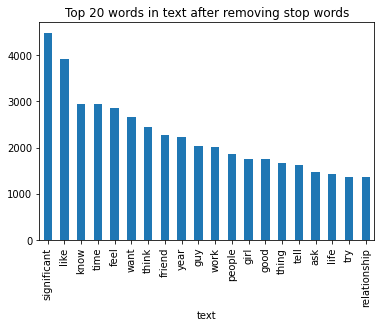

In [42]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(data['text'], 20)

for word, freq in common_words:
    print(word, freq)

df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df2.groupby('text').sum()['count'].sort_values(ascending=False).plot.bar(
    title='Top 20 words in text after removing stop words')


not know 595
feel like 566
not want 456
will not 292
prof ben 267
not think 232
feel significant 221
significant not 213
be sure 206
not like 173
not feel 165
date app 163
good friend 154
year ago 144
not help 136
spend time 134
like not 130
go to 123
social medium 119
close friend 118


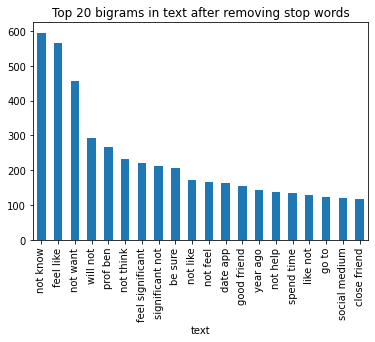

In [43]:
# distribution of top bigrams after removing stop words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(data['text'], 20)

for word, freq in common_words:
    print(word, freq)

df4 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df4.groupby('text').sum()['count'].sort_values(ascending=False).plot.bar(
    title='Top 20 bigrams in text after removing stop words')

hi prof ben 66
feel like be 55
not help feel 40
dear prof ben 34
not feel like 34
not know feel 27
long term relationship 25
long story short 24
time feel like 24
feel like not 20
not know be 20
make feel like 20
admin not filter 19
be go to 19
be pretty sure 18
not want lose 18
meet new people 17
not stop think 17
significant not know 16
will not able 16


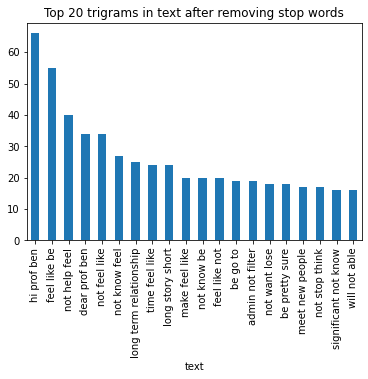

In [44]:
# distribution of Top trigrams after removing stop words
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(data['text'], 20)

for word, freq in common_words:
    print(word, freq)

df5 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df5.groupby('text').sum()['count'].sort_values(ascending=False).plot.bar(
    title='Top 20 trigrams in text after removing stop words')

In [45]:
# explore topic modelling algorithm with this dataset
# experiment with Latent Semantic Analysis (LSA) technique in topic modelling
# to better understand each topic, we find the most frequent 3 words in each topic
# will tell us if topic modelling techniques will be useful for our project
# eg whether we will reach any degree of separation across topic categories

reindexed_data = data['text']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)
n_topics = 10 # adjust this
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
    
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words
    
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  significant like feel
Topic 2:  student module job
Topic 3:  girl guy module
Topic 4:  job pay salary
Topic 5:  friend close people
Topic 6:  parent pay money
Topic 7:  week wait ep
Topic 8:  year module relationship
Topic 9:  prof ben hi
Topic 10:  people nuswhisper comment


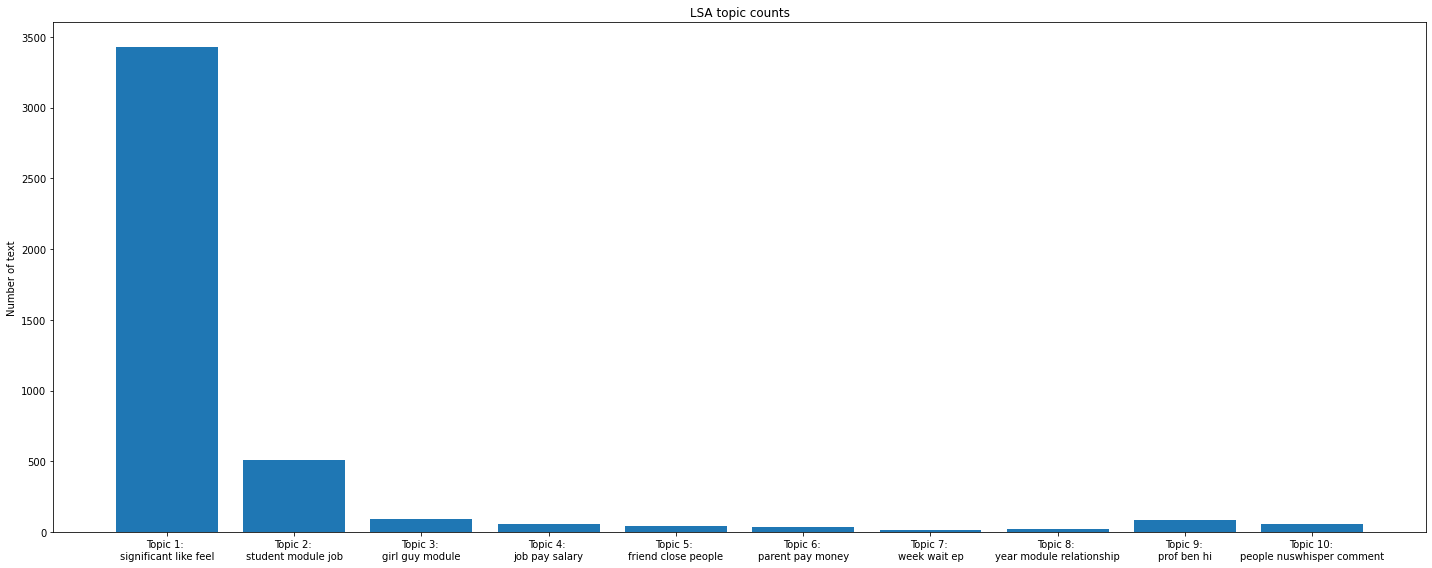

In [46]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i+1) + top_3_words[i] for i in lsa_categories]
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of text');
ax.set_title('LSA topic counts');
fig.tight_layout()
plt.show();